In [38]:
import matplotlib.pyplot as plt
import datetime
import tilemapbase as tmb
import numpy as np
import pandas as pd
from pluma.stream.georeference import Georeference
from pluma.stream.ubx import _UBX_MSGIDS
from pluma.schema import Dataset
from pluma.io.harp import read_harp_bin

## Notebook plotting
%matplotlib inline
plt.style.use('ggplot')

## Figure export parameters
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
import matplotlib as mpl
mpl.rcParams.update(new_rc_params)



In [39]:
stream_root_folder = r'C:\Users\neurogears\Desktop\emocitiesdatasets\Collection2023_07_21_12_22_27' #using RJ45 to router
#stream_root_folder = r'C:\Users\neurogears\Desktop\emocitiesdatasets\Collection2023_07_21_12_49_45' #using wifi

from benchmark_schemas import build_benchmarkschema_pupillabs

dataset = Dataset(
    stream_root_folder,
    datasetlabel="PupilLabs_Benchmark",
    georeference= Georeference(),
    schema=build_benchmarkschema_pupillabs)
dataset.populate_streams(autoload=True)


C:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\neurogears\Desktop\emocitiesdatasets\Collection2023_07_21_12_22_27\Streams_33 could not be found.
  warnings.warn(f'Harp stream file\
C:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\neurogears\Desktop\emocitiesdatasets\Collection2023_07_21_12_22_27\Streams_211 could not be found.
  warnings.warn(f'Harp stream file\
C:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\neurogears\Desktop\emocitiesdatasets\Collection2023_07_21_12_22_27\Streams_213 could not be found.
  warnings.warn(f'Harp stream file\
C:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\neurogea

In [40]:
## Check corrupted frames
video_path = stream_root_folder + r'\pupil_video.avi'
import cv2

cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # returns the correct number of frames
print('Number of frames: ', frame_count)

Number of frames:  45221


In [41]:

counter = dataset.streams.PupilLabs.Counter.DecodedFrames.data
## Load luminance data tracked from the video
lum = pd.read_csv(stream_root_folder + r'\pupil_luminance.csv', header=None, names=['lum'])
print(f"NumberOfFrames: {frame_count}\nNumberOfLum: {len(lum)}\nNumberOfDecodedFrames: {len(counter[counter.values==1])}\nNumberOfRawZMQFrames: {len(dataset.streams.PupilLabs.Counter.RawFrames.data)}")

decoded_counter = dataset.streams.PupilLabs.Counter.DecodedFrames.data.loc[dataset.streams.PupilLabs.Counter.DecodedFrames.data.values==1,:]
decoded_counter.loc[:,"lum"] = lum.values
decoded_counter

NumberOfFrames: 45221
NumberOfLum: 45221
NumberOfDecodedFrames: 45221
NumberOfRawZMQFrames: 45223


C:\Users\neurogears\AppData\Local\Temp\ipykernel_25404\3711122885.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decoded_counter.loc[:,"lum"] = lum.values


,Value,lum
Seconds,,
1904-01-02 20:52:44.497984,1,15377
1904-01-02 20:52:44.517984,1,14724
1904-01-02 20:52:44.544992,1,14316
1904-01-02 20:52:44.577984,1,14537
1904-01-02 20:52:44.612992,1,14397
...,...,...
1904-01-02 21:17:51.128000,1,11208
1904-01-02 21:17:51.128000,1,11195
1904-01-02 21:17:51.128000,1,11362


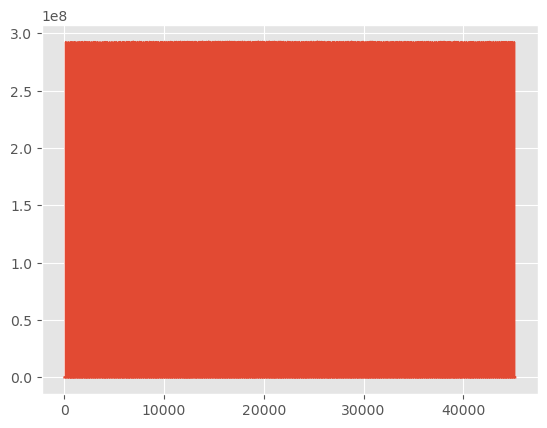

In [42]:
plt.figure()
plt.plot(decoded_counter["lum"].values)
plt.show()


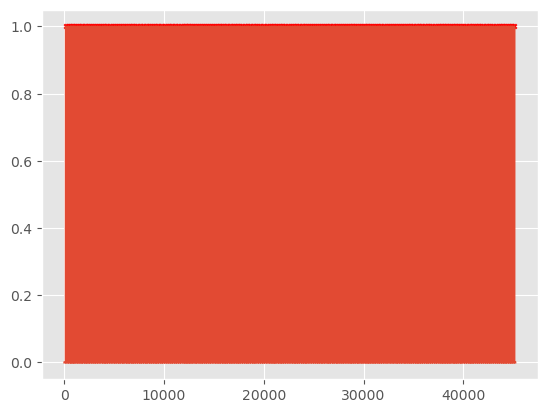

In [43]:

##Find rising edges in the video
threshold = 0.5e8
ttl = (decoded_counter['lum'].values > threshold).astype(int)
ttlwhere = np.where(np.diff(ttl) == 1)[0] +2

plt.figure()
plt.plot(ttl)
plt.scatter(ttlwhere, ttlwhere*0+1, c='r', marker='x', s=10)
plt.show()

rising_edge_camera = decoded_counter.index.values[ttlwhere]

## find rising edges in harp
dataset.streams.BioData.Set.data = dataset.streams.BioData.Set.data[~dataset.streams.BioData.Set.data.index.duplicated(keep='first')]
bit_mask = 1024
rising_edge_harp = dataset.streams.BioData.Set.data[dataset.streams.BioData.Set.data & bit_mask > 0].index.values



234
234


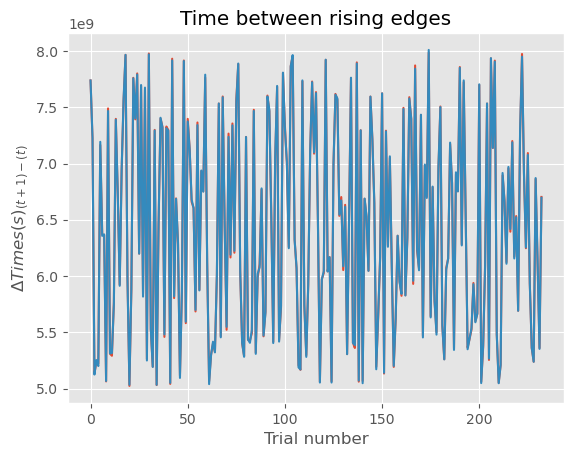

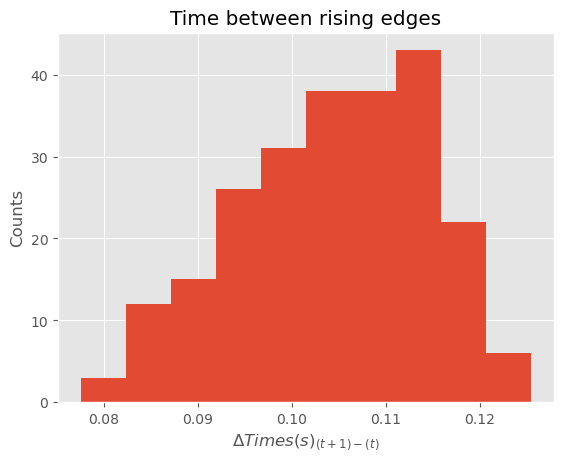

In [52]:
print(len(rising_edge_camera))
print(len(rising_edge_harp))

plt.figure()
plt.plot(np.diff(rising_edge_camera))
plt.plot(np.diff(rising_edge_harp))

plt.xlabel('Trial number')
plt.ylabel('$\Delta Times(s)_{(t+1) - (t)}$')
plt.title("Time between rising edges")
plt.show()


plt.figure(figsize= (9,6))
delta_t = (rising_edge_camera - rising_edge_harp[:len(rising_edge_camera)]) / np.timedelta64(1000, 'ms')
plt.hist(delta_t, bins = 50, color= "Teal")
plt.ylabel('Counts')
plt.xlabel('$\Delta Times(s)_{(t+1) - (t)}$')
plt.title(f'Pupil latency benchmark\n$\mu = {np.mean(delta_t):.2f}, \sigma = {np.std(delta_t):.2f},$ [min:max] = [{np.min(delta_t):.2f}:{np.max(delta_t):.2f}]')
plt.show()
